In [1]:
#!pip install scikit-image

In [2]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify

import torch
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
import fiona
from shapely.geometry import shape
import cv2
from pytorch_segmentation.inference import mosaic_to_raster
from pytorch_segmentation.data.inference_dataset import SatInferenceDataset
from pytorch_segmentation.utils.helper import split_raster_to_grid
from pytorch_segmentation.tree_segmentation import segment_trees
#from pytorch_segmentation.utils.preprocessing import unpatchify,pad_image_topleft


seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


patch_size = [256,256] # [x,y,bands]
overlap = 128
padding = 64

bval = (255,255,255)
nworkers = 4
bs = 16

dataset_path = "data/datasets/inference_data.pkl"
data_path = "/home/jovyan/work/satellite_data/tmp/2014.vrt"
shape_path = "/home/jovyan/work/notebooks/satellite_data/data/sa_train_shapes/sa_train_shapes_2014.geojson"
#shape_path = "/home/jovyan/work/notebooks/satellite_data/utils/shapes/2015.shp"#"/home/jovyan/work/satellite_data/tmp/shapes/25/2018.shp"

model_name = "unet_08_12_2022_153943"#"unet_18_07_2022_150108_new"# #"unet_24_05_2022_141620"
model_path = "saved_models/" + model_name +  ".pth" #unet_15_03_2022_071331.pth" #unet_24_03_2022_064749.pth
out_path = "data/out/"+model_name

In [3]:
# data_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/images/test/test_rwanda.vrt"

# shape_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/Training_rectangles/rectangles_model_29.shp"

# 1. Data Loading and Preprocessing

In [4]:


dataset = SatInferenceDataset(data_file_path=data_path,shape_file=shape_path,overlap=128,padding=64,rescale_factor=1)
#dataset = SatInferenceDataset(data_file_path=data_path,shape_file=shape_path,overlap=64,padding=32,rescale_factor=2)
shapes = dataset.shapes.copy()
dataset.save(dataset_path)
 
#del dataset


100%|██████████| 3/3 [00:00<00:00, 1376.84it/s]


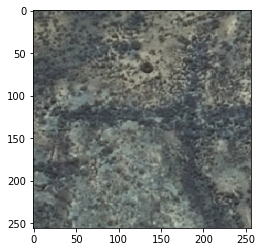

In [5]:
dataset.get_img(2)

# 2. UNet 


# 2.2 Unet

In [6]:
state_dict = torch.load(model_path)
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v


In [7]:
from pytorch_segmentation.models import UNet
net = UNet(n_channels=3, n_classes=2, bilinear=False)
#net.load_state_dict(new_state_dict)
net.load_state_dict(torch.load(model_path,map_location="cpu"))
#net = net.to(device)
net.eval();



# Multi Process Queue In-Memory

In [8]:
from pytorch_segmentation.inference import mosaic_to_raster_mp_queue_memory
ofiles = mosaic_to_raster(dataset_path,shapes,net,out_path,device_ids=[0,1],
                          bs=150,pin_memory=True,num_workers=15)

Total number of shapes:  3
Shape:  0
Queue PID:  19999


  0%|          | 0/16 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1


100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

DONE  0


INFO: Written data/out/unet_01_12_2022_085945_new/sa_train_shapes_2014_1.tif in 0.030 seconds
Shape:  1
Queue PID:  19999


  0%|          | 0/16 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0


100%|██████████| 16/16 [00:05<00:00,  2.96it/s]

DONE  0


INFO: Written data/out/unet_01_12_2022_085945_new/sa_train_shapes_2014_2.tif in 0.024 seconds
Shape:  2
Queue PID:  19999


  0%|          | 0/16 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1


  6%|▋         | 1/16 [00:05<01:15,  5.03s/it]

DONE  0


100%|██████████| 16/16 [00:05<00:00,  3.00it/s]


INFO: Written data/out/unet_01_12_2022_085945_new/sa_train_shapes_2014_3.tif in 0.024 seconds


# Segment trees

In [9]:
for f in ofiles:
    out_file = f.split(".")[0] + ".geojson"
    segment_trees(f,out_file,n_cpus=10)

0it [00:00, ?it/s]


Finished in: 1.34370756149292 seconds
Number of segmented trees:  228


0it [00:00, ?it/s]


Finished in: 1.2981653213500977 seconds
Number of segmented trees:  219


0it [00:00, ?it/s]


Finished in: 1.5701472759246826 seconds
Number of segmented trees:  482


# Backlog

## 2.1. Simple Unet
https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705

In [ ]:
from pytorch_segmentation.models.unet_simple import UNet

net = UNet(patch_size[2],2)
net = net.load_state_dict(torch.load(model_path)).to(device)
net.eval()

In [11]:
output = []
#out = net(X.to(device))
for i,batch in enumerate(dl):
    x = batch.to(device)#[0].to(device)
    out = net(x)
    out = F.softmax(out,dim=1)
    out = torch.argmax(out,dim=1)
    out = out.cpu().numpy().astype("uint8")
    output.append(out)
imgs = np.vstack(output)

In [8]:
out_image = unpatchify(imgs,patches.shape[:2],pad)
out_meta = satellite_img.meta.copy()
out_meta.update({"driver": "GTiff",
                 "count":1,
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": sat_patch_arr_transform})
with rasterio.open(out_file, "w", **out_meta) as dest:
    dest.write(out_image)

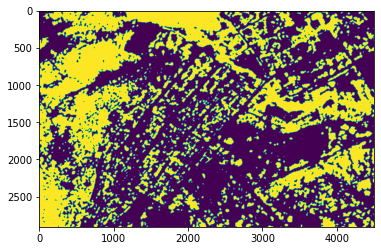

In [9]:
show(out_image);

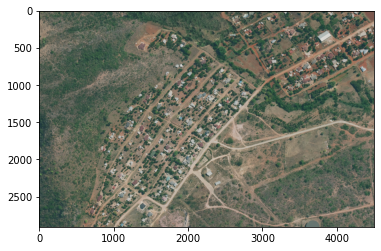

In [10]:
show(sat_patch_arr);

In [16]:
out_image = sat_patch_arr
out_meta = satellite_img.meta.copy()
out_meta.update({"driver": "GTiff",
                 "count":3,
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": sat_patch_arr_transform})
with rasterio.open('data/out/raster.tif', "w", **out_meta) as dest:
    dest.write(out_image)

## Single Process 

In [ ]:
mosaic_to_raster(dataset,net,"data/out/",device_ids=[0,1,2,3,4],bs=650,pin_memory=True,num_workers=20)

# Multi Process

In [ ]:
from pytorch_segmentation.utils.postprocessing import mosaic_to_raster_mp
mosaic_to_raster_mp(dataset_path,net,"data/out/",device_ids=[0,2,3,4],bs=150,pin_memory=True,num_workers=8)

## Multi Process Queue

In [ ]:
from pytorch_segmentation.utils.postprocessing import mosaic_to_raster_mp_queue
mosaic_to_raster_mp_queue(dataset_path,net,"data/out/",mmap_shape=(len_dataset,256,256),device_ids=[0,1,2,3,4],
                          bs=150,pin_memory=True,num_workers=10)